# Visualize saliency maps

# <span style="color:red"> **NOTE** </span>

### <span style="color:red"> This code is mostly copies from the github page below: </span> 
https://github.com/sunnynevarekar/pytorch-saliency-maps

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from skimage.util import random_noise, img_as_ubyte

## Instantiate pretrained GoogleNet model

In [3]:
#load pretrained googlenet model
model = torchvision.models.googlenet(pretrained=True)
print(model)

#define transforms to preprocess input image into format expected by model
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
#inverse transform to get normalize image back to original form for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

#transforms to resize image to the size expected by pretrained model,
#convert PIL image to tensor, and
#normalize the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,          
])

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

### Functions for computing saliency and noise

In [4]:
# Same function as in saltnpepper.ipynb for adding noise
def add_noise(im, amount=0.5):
    im_arr = np.asarray(im)
    
    noise_img = random_noise(im_arr, mode='s&p', amount=amount)
    noise_img = (255*noise_img).astype(np.uint8)

    return Image.fromarray(noise_img)

In [37]:

def saliency(img, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()
    #transform input PIL image to torch.Tensor and normalize
    input = transform(img)
    input.unsqueeze_(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    #apply inverse transform on image
    with torch.no_grad():
        input_img = inv_normalize(input[0])
    #plot image and its saleincy map
    # plt.figure(figsize=(10, 10))
    # plt.subplot(1, 2, 1)
    # plt.imshow(img)
    # plt.xticks([])
    # plt.yticks([])
    # plt.subplot(1, 2, 2)
    # plt.imshow(slc.numpy(), cmap=plt.cm.hot)
    # plt.xticks([])
    # plt.yticks([])
    # plt.show()
    return slc.numpy()

# Plot saliency for noise and unnoisy images

### Compute saliencies

In [66]:
img_org = Image.open(f"tcav/data/data_no_noise/zebra/14.jpg").convert('RGB')

img_noise = add_noise(img_org, amount=0.5)

res_org = saliency(img_org, model)
res_noise = saliency(img_noise, model)

/var/folders/kg/87d0nmxn11xbzs39mwh7hjvr0000gn/T/ipykernel_15770/1706767584.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


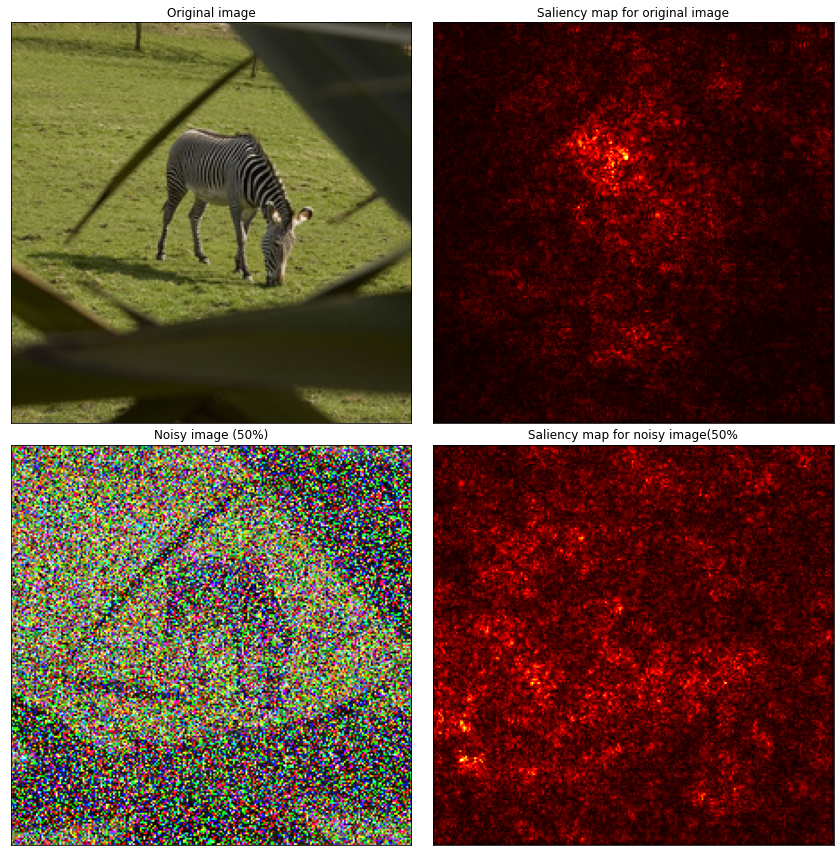

In [67]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(12, 12))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 2),
                 axes_pad=0.3, share_all=True)

grid[0].set_xticks([])
grid[0].set_yticks([])
grid[0].set_title("Original image")
grid[1].set_title("Saliency map for original image")
grid[2].set_title("Noisy image (50%)")
grid[3].set_title("Saliency map for noisy image(50%")

for ax, im in zip(grid, [img_org, res_org, img_noise, res_noise]):
    ax.imshow(im, cmap=plt.cm.hot)

plt.tight_layout()

# plt.savefig("results/plots/saliencies.jpg")
plt.show()